In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import cv2 as cv
from skimage.segmentation import slic

import findatree.io as io
import findatree.visualize as visual
import findatree.segmentation as segment

importlib.reload(segment)

plt.style.use(r"C:\Repos\findatree\own.mplstyle")

### Define raster-files and print infos

In [2]:
importlib.reload(io)
dir_names=[]
dir_names.extend([r'C:\Data\lwf\DSM_2021'])
dir_names.extend([r'C:\Data\lwf\DTM'])
dir_names.extend([r'C:\Data\lwf\Orthophotos_2021'])

file_names=[]
file_names.extend(['Tnr_12702_D-20210713_DSM.tif'])
file_names.extend(['tnr_12702_dtm.tif'])
file_names.extend(['Tnr_12702_2021_Ortho.tif'])


paths=[os.path.join(dir_names[i],file_name) for i, file_name in enumerate(file_names)]

io.print_raster_info(paths)


(0)
Name: C:/Data/lwf/DSM_2021/Tnr_12702_D-20210713_DSM.tif
Width[px]: 4749
Height[px]: 4626
No. of rasters: 1
  Index: 1, dtype: float32
Nodata values: (-32767.0,)

Coordinate reference system CRS: EPSG:25832
Geo bounds: BoundingBox(left=661774.3636313608, bottom=5470426.000381344, right=662196.9573473627, top=5470837.648840014)
Affine geo-transfrom: [0.08898583196501086, 0.0, 661774.3636313608, 0.0, -0.0889858319649575, 5470837.648840014]

(1)
Name: C:/Data/lwf/DTM/tnr_12702_dtm.tif
Width[px]: 398
Height[px]: 409
No. of rasters: 1
  Index: 1, dtype: float32
Nodata values: (-3.4028234663852886e+38,)

Coordinate reference system CRS: EPSG:25832
Geo bounds: BoundingBox(left=661789.9361519547, bottom=5470428.936913799, right=662187.9361519547, top=5470837.936913799)
Affine geo-transfrom: [1.0, 0.0, 661789.9361519547, 0.0, -1.0, 5470837.936913799]

(2)
Name: C:/Data/lwf/Orthophotos_2021/Tnr_12702_2021_Ortho.tif
Width[px]: 7913
Height[px]: 8617
No. of rasters: 5
  Index: 1, dtype: uint16


### Reproject raster-files to same area & resolution

In [3]:
importlib.reload(io)
res = 0.25
bands, mask, A, bound = io.reproject_all_intersect(paths, res=res)

C:\Users\flori\Anaconda3\envs\findatree_v01\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


### Define and normalize channels

In [4]:
importlib.reload(segment)

##################### Primary channels
chm = (bands[0][:,:,0] - bands[1][:,:,0]).astype(np.float32)

blue = (bands[2][:,:,0] / (2**16 - 1)).astype(np.float32)
green = (bands[2][:,:,1] / (2**16 - 1)).astype(np.float32)
red = (bands[2][:,:,2] / (2**16 - 1)).astype(np.float32)
re = (bands[2][:,:,2] / (2**16 - 1)).astype(np.float32)
nir = (bands[2][:,:,4] / (2**16 - 1)).astype(np.float32)

##################### Secondary channels
# NDVI: Normalized difference vegetation index
ndvi = (nir - red) / (nir + red) 

# NDVI: Normalized green-red difference index
ngrdi = (green - red) / (green + red)

# RGB
RGB = np.zeros((red.shape[0], red.shape[1], 3), dtype=np.float32)
RGB[:,:,0] = blue
RGB[:,:,1] = green
RGB[:,:,2] = red
rgb = np.prod(RGB, axis=2)**(1/3)
# rgb = np.mean(RGB, axis=2)

# HLS
HLS = cv.cvtColor(RGB, cv.COLOR_RGB2HLS)
H = HLS[:,:,0]
L = HLS[:,:,1]
S = HLS[:,:,2]

### Plotting of channels


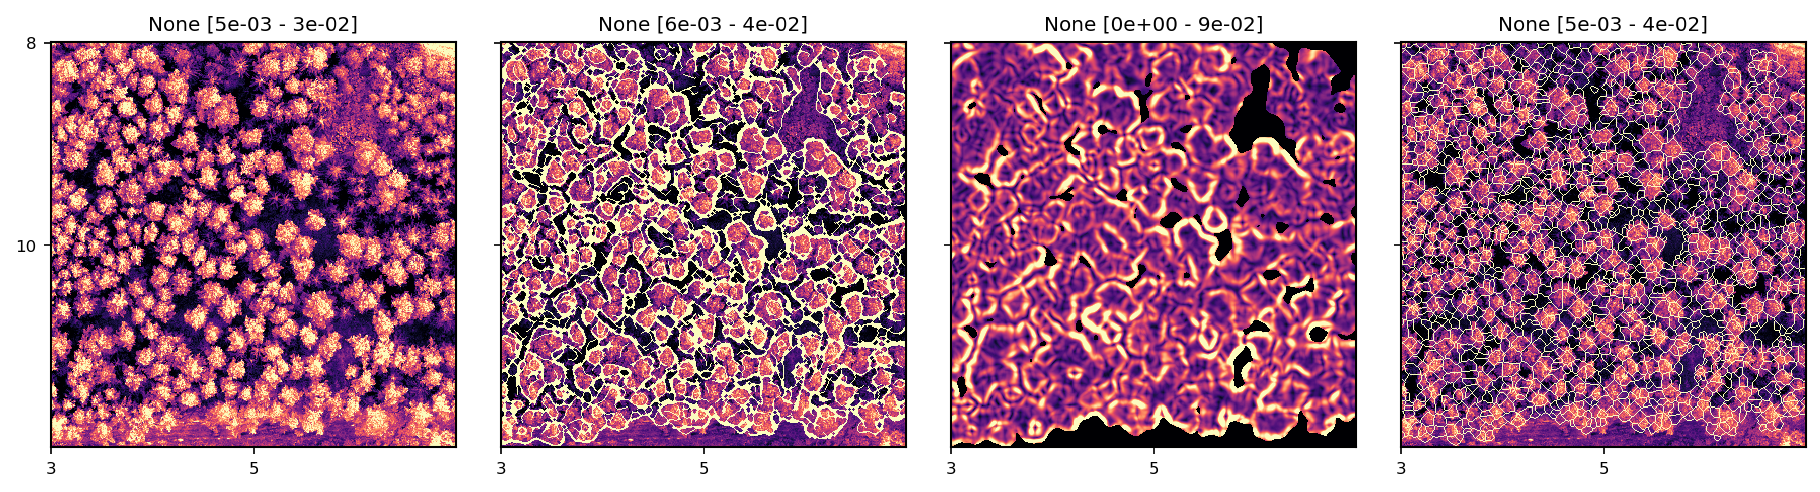

In [26]:
importlib.reload(visual)
importlib.reload(segment)

# Mask of positives
mask = (segment.blur(chm) > 3) & (segment.blur(ndvi) > 0.6) & (segment.blur(L) > 6e-3)

# Gradients and edges of each channel
channels = [chm, H, L, S, ndvi]
grad_all, edge_sum, ws_out = segment.seeds_by_gradient(channels, mask)

# Define picture with enclosed regions for illustration
L_edge = L.copy()
L_edge[edge_sum == 1] = 3.5e-2
L_ws = L.copy()
L_ws[ws_out == -1] = 3.5e-2

channels = [
    L, L_edge, grad_all, L_ws,
]

xylim = [(500, 200), (1000, 200)]
f, axs = visual.show_channels(
    channels,
    xylim=xylim,
    # mask=mask,
    zoom=1,
    # n_cols_rows=[5,2],
    # use_random_cmap=use_random_cmap,
)

Text(0.5, 1.0, 'NDVI')

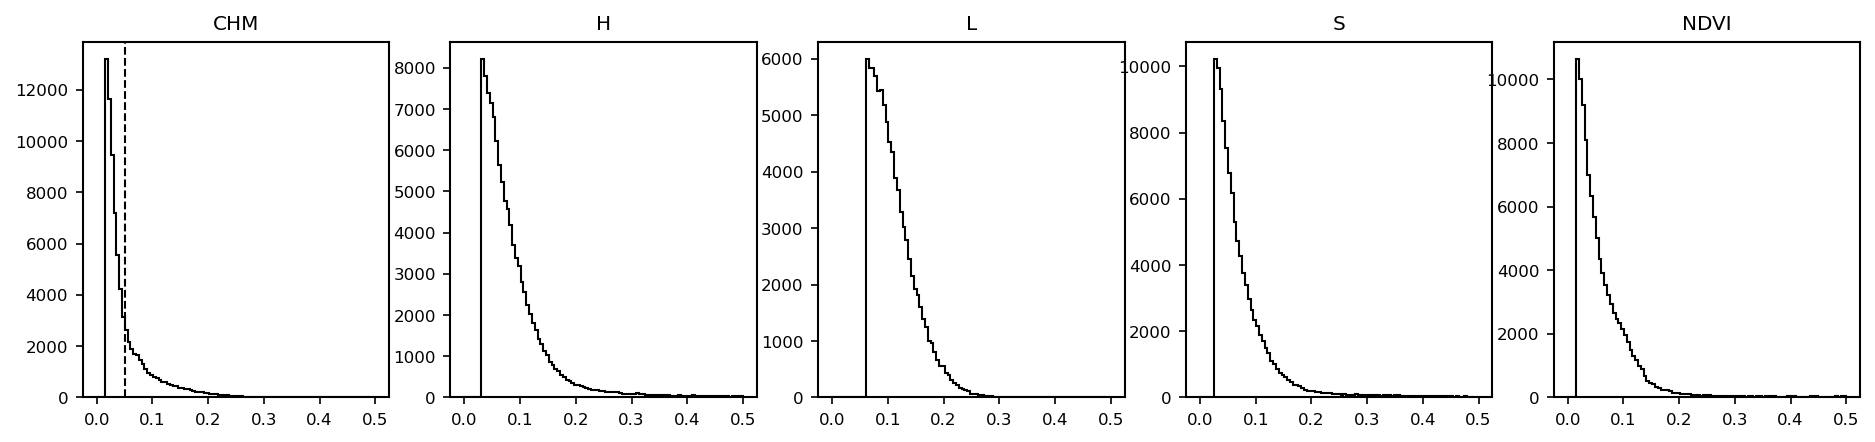

In [61]:
perc_lower = 50
f, axs =plt.subplots(ncols=5, figsize=(15,3))

ax = axs[0]
x = chm_edge[mask]
x = x[x>0]
hist = ax.hist(x, histtype='step', bins=np.linspace(0,0.5,100), ec='k')
ax.axvline(np.mean(x), ls='--', c='k')
ax.set_title('CHM')

ax = axs[1]
x = H_edge[mask]
x = x[x>0]
hist = ax.hist(x, histtype='step', bins=np.linspace(0,0.5,100), ec='k')
# ax.axvline(hist[1][np.argmax(hist[0])], ls='--', c='k')
_ = ax.set_title('H')

ax = axs[2]
x = L_edge[mask]
x = x[x>0]
hist = ax.hist(x, histtype='step', bins=np.linspace(0,0.5,100), ec='k')
# ax.axvline(hist[1][np.argmax(hist[0])], ls='--', c='k')
ax.set_title('L')

ax = axs[3]
x = S_edge[mask]
x = x[x>0]
hist = ax.hist(x, histtype='step', bins=np.linspace(0,0.5,100), ec='k')
# ax.axvline(hist[1][np.argmax(hist[0])], ls='--', c='k')
_ = ax.set_title('S')

ax = axs[4]
x = ndvi_edge[mask]
x = x[x>0]
hist = ax.hist(x, histtype='step', bins=np.linspace(0,0.5,100), ec='k')
# ax.axvline(hist[1][np.argmax(hist[0])], ls='--', c='k')
ax.set_title('NDVI')


### Generate markers for marker-controlled watershed

In [116]:
##################### Define image used for creating markers for watershed
img_obj = C
img_obj[np.invert(mask)] = np.nan

img_obj -= np.nanmin(img_obj.flatten())
img_obj *= 255 / np.nanmax(img_obj.flatten())
img_obj = img_obj.astype(np.uint8)

##################### Blur
# img_blur = segment.blur(img_obj)
img_blur = img_obj.copy()

##################### Gaussian adaptive thresholding -> mask
mask = cv.adaptiveThreshold(
    img_blur, 1, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv.THRESH_BINARY, 241, 0,
)
# kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
# mask = cv.dilate(mask, kernel, iterations=1)

##################### Divide connected regions into sub-regions based on distance transform, this will be our sure foreground
sure_fg= mask.copy()
for i in range(15):
    sure_fg = segment.divide_connectedComponents(sure_fg, percentile=50)

### Marker-controlled watershed

In [119]:
##################### Dilate inital mask to create a thiner, sure background
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
sure_bg = cv.dilate(mask, kernel, iterations=5)

##################### Dilate sure_fg a bit to get a better seed for the watershed
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
seed = cv.dilate(sure_fg, kernel, iterations=1)

##################### Unknow area 
unkown = sure_bg - seed

##################### Get connnected compontents of the seed
ret, markers = cv.connectedComponents(seed)

##################### Prepare final markers for watershedding, must be of dtype=np.uint32
# sure_bg -> 1
# unknown -> 0
# seed -> >=2
markers = markers + 1 - unkown
markers = markers.astype(np.int32)

##################### Prepare image for watershedding, must be of dtype=np.uint8 with shape (m,n,3)
S_blur = segment.blur(S)
S_blur -= np.nanmin(S_blur.flatten())
S_blur *= (255 / np.nanmax(S_blur.flatten()))

ndvi_blur = segment.blur(ndvi)
ndvi_blur -= np.nanmin(ndvi_blur.flatten())
ndvi_blur *= (255 / np.nanmax(ndvi_blur.flatten()))

img = np.zeros((nir.shape[0], nir.shape[1], 3), dtype=np.uint8)
for i in range(3):
    img[:,:,i] = mask * C


##################### Watershed
markers = cv.watershed(img, markers)

img_obj_vis = img_obj.copy()
img_obj_vis[markers == -1] = 255

### Plotting of segmentation results

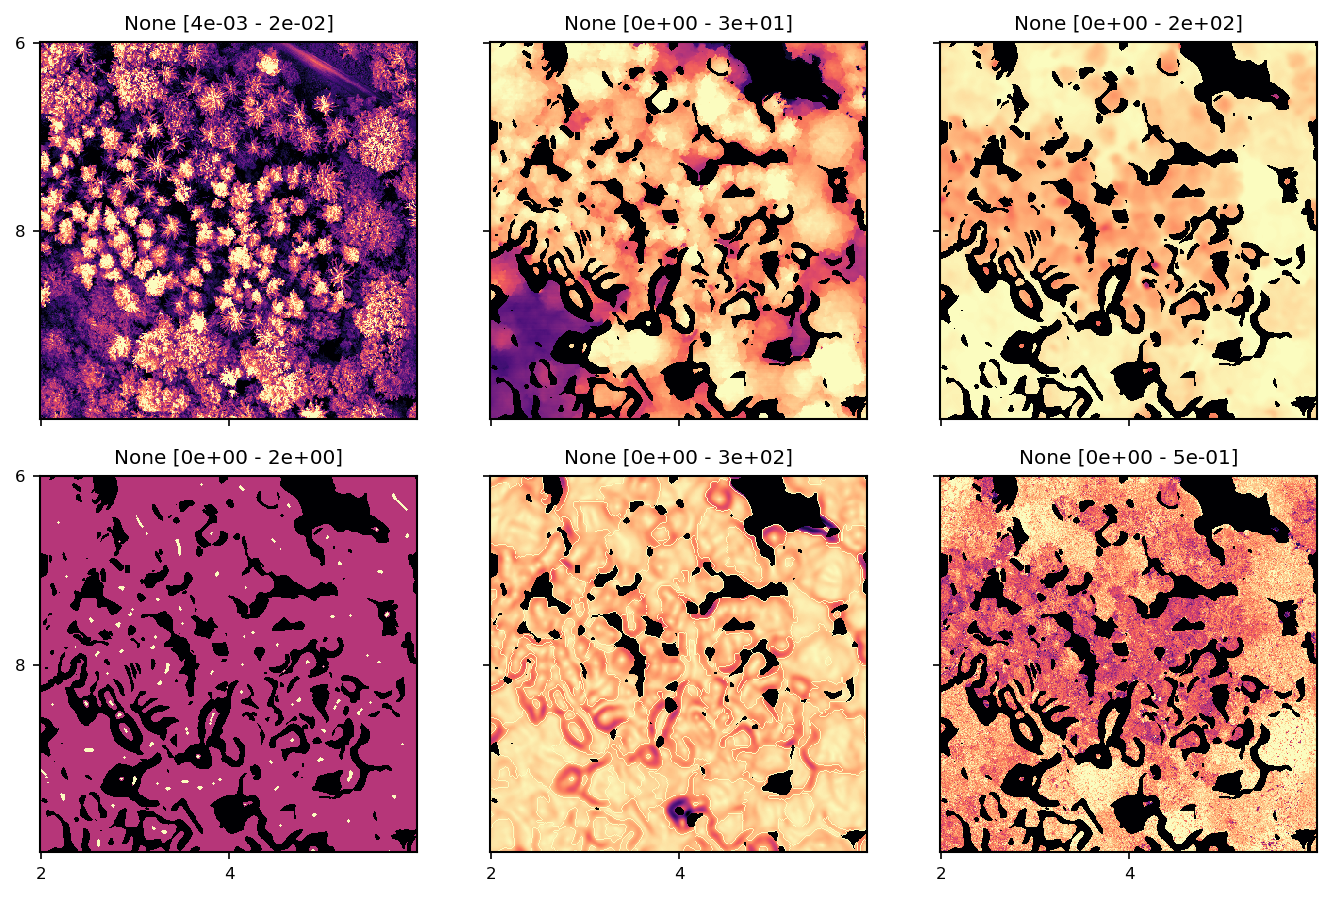

In [120]:
importlib.reload(visual)


channels = [rgb, mask*chm, mask*ndvi_blur, mask+seed, img_obj_vis, mask*S]

f, axs = visual.show_channels(
    channels,
    xylim=xylim,
    n_cols_rows=[3,2],
    zoom=1,
)

# plt.savefig(r'C:\Users\flori\Desktop\plots\220228_WKS-DIN_P4MS_non-blur.pdf', transparent=True)